## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [29]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [30]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
print(images)
# Step through the list and search for chessboard corners
shape = ()
for fname in images:
    img = cv2.imread(fname)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    shape=gray.shape
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

['camera_cal/calibration10.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration9.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration1.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration5.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration14.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration12.jpg']


Calibrate the camera


In [31]:
print(shape)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
def undistortImage(image):
    undist_image = cv2.undistort(image,mtx,dist,None,mtx)
    return undist_image

(720, 1280)


before finding lanes,there are 4 steps needed to be done.
First, camera calibration
Second, distortion correction
Third, color & gradient threshold
Fourth, perspective transform.
Fifth, find lanes
Sixth, calculate curvature.





In [32]:
from moviepy.editor import *
from IPython.display import HTML
videofile = "challenge_video.mp4"
clip = VideoFileClip(videofile)
duration = clip.duration
print(clip.duration)


16.15


In [33]:
import random
choices = random.sample(range(int(duration*100)),5)
files = []
for index in choices:
    index = index/100.00
    filename = "grabed_images/"+"image_"+str(index)+".jpg";
    files.append(filename)
    clip.save_frame(filename,index,False)
    print(index)
print(choices)
print(files)

11.51
8.88
5.91
8.09
2.98
[1151, 888, 591, 809, 298]
['grabed_images/image_11.51.jpg', 'grabed_images/image_8.88.jpg', 'grabed_images/image_5.91.jpg', 'grabed_images/image_8.09.jpg', 'grabed_images/image_2.98.jpg']


(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


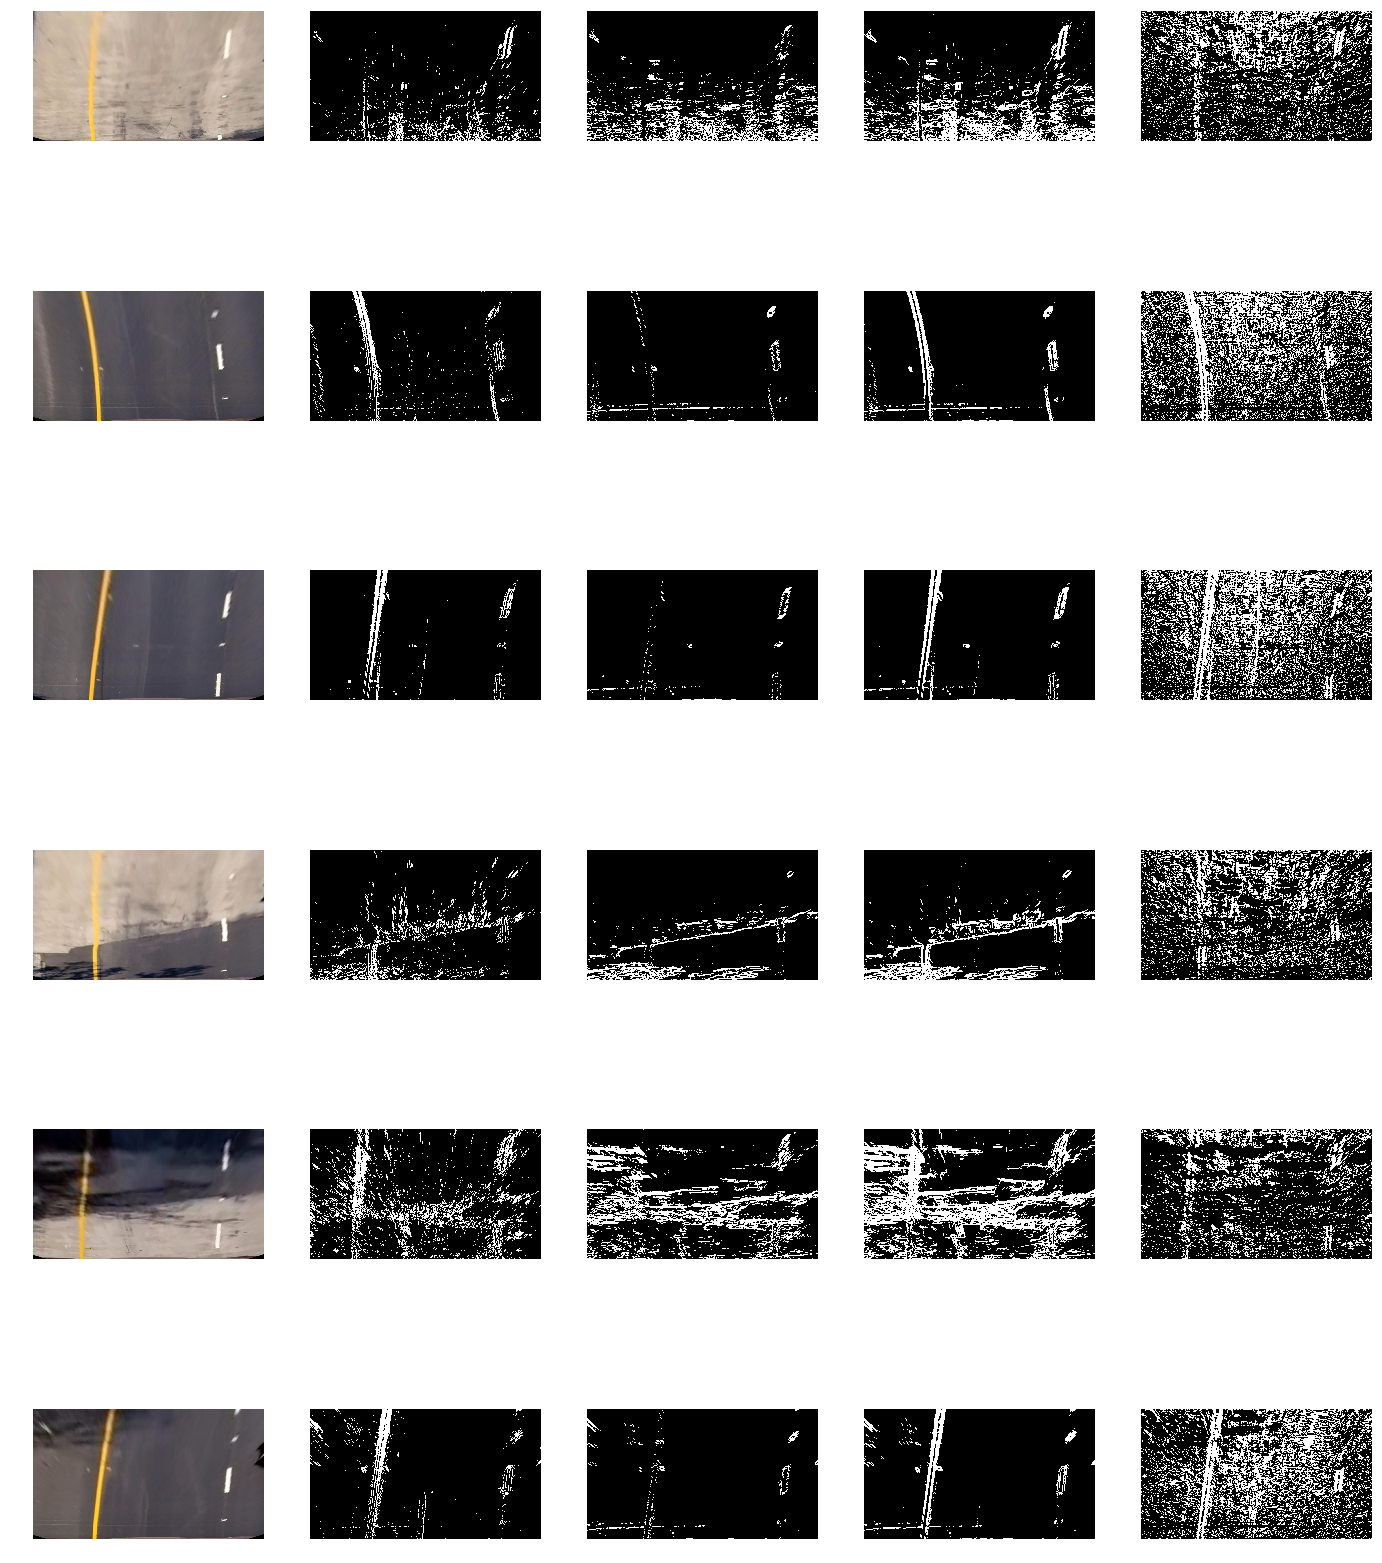

In [34]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import scipy.misc
thresh_min = 15
thresh_max = 18
def grayScale(image):
    
    return cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
def abs_sobel_thresh(gray_image,orient='x',ksize=3,thresh=(0,255)):
    if orient == 'x':
        sobelx = cv2.Sobel(gray_image,cv2.CV_64F,1,0,ksize = ksize)
    else:
        sobelx = cv2.Sobel(gray_image,cv2.CV_64F,0,1,ksize = ksize)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary
def mag_thresh(img, ksize=3, thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=ksize)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output
def dir_threshold(img, ksize=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

fig = plt.figure(figsize = (24,30))
for i in range(6):
    image = mpimg.imread('test_images/warped'+str(i+1)+'.jpg') # read the center image
    image = cv2.GaussianBlur(image, (3, 3), 0)
    a = fig.add_subplot(6,5,1+5*i)
    print(image.shape)
    a.axis("off")
    plt.imshow(image)
    undist = undistortImage(image)
    gray = grayScale(undist)
    new_image = abs_sobel_thresh(gray,orient='x',ksize=3,thresh=(10,70))
    a = fig.add_subplot(6,5,2+5*i)
    a.axis("off")
    plt.imshow(new_image,cmap="gray")
    
  
    new_image1 = abs_sobel_thresh(gray,orient='y',ksize=3,thresh=(10,70))
    a = fig.add_subplot(6,5,3+5*i)
    a.axis("off")
    plt.imshow(new_image1,cmap="gray")
    

    new_image2 = mag_thresh(gray,ksize=5,thresh=(10,80))
    a = fig.add_subplot(6,5,4+5*i)
    a.axis("off")
    plt.imshow(new_image2,cmap="gray")
    

    new_image4 = dir_threshold(gray,ksize=15,thresh=(0,0.4))
    a = fig.add_subplot(6,5,5+5*i)
    a.axis("off")
    plt.imshow(new_image4,cmap="gray")
    
#     a = fig.add_subplot(5,2,9)
#     print(image.shape)
#     a.axis("off")
#     plt.imshow(image)
#     new_image5 = conbinedThresh(gray)
#     a = fig.add_subplot(5,2,10)
#     a.axis("off")
#     plt.imshow(new_image5,cmap="gray")

    
    

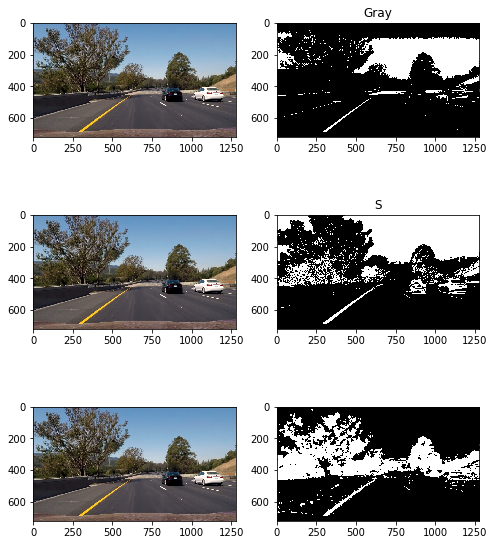

In [35]:
image = mpimg.imread("test_images/test6.jpg")
thresh = (150,220)
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray>thresh[0]) & (gray <= thresh[1])] = 1

fig = plt.figure(figsize = (8,10))
a = fig.add_subplot(3,2,1)
plt.imshow(image)
a = fig.add_subplot(3,2,2)
plt.imshow(binary,cmap="gray")
plt.title("Gray")

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
thresh = (80, 255)
binarys = np.zeros_like(S)
binarys[(S > thresh[0]) & (S <= thresh[1])] = 1

a = fig.add_subplot(3,2,3)
plt.imshow(image)
a = fig.add_subplot(3,2,4)
# a.title="S"
plt.imshow(binarys,cmap="gray")
plt.title("S")





thresh = (15, 100)
binaryh = np.zeros_like(H)
binaryh[(H > thresh[0]) & (H <= thresh[1])] = 1

a = fig.add_subplot(3,2,5)
plt.imshow(image)
a = fig.add_subplot(3,2,6)
# plt.imshow(colorThreshold(image),cmap="gray")
plt.imshow(binaryh,cmap="gray")




In [64]:
p1 = "test_images/straight_lines1.jpg"
p1 = "test_images/test1.jpg"
image = mpimg.imread(p1)
image = undistortImage(image)
img_size = (image.shape[1],image.shape[0])
src = np.float32([[570,470],[715,470],[1040,685],[255,685]])
# dst = np.float32([[255,470],[1040,470],[1040,685],[255,685]])
xoffset = 300
yoffset = 0
dst = np.float32([[xoffset,yoffset],[img_size[0]-xoffset,yoffset],
                  [img_size[0]-xoffset,img_size[1]-yoffset],[xoffset,img_size[1]-yoffset]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

def warpImage(image):
    img_size=(image.shape[1],image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size)
    return warped

In [65]:
def process_image(img):
    img = undistortImage(img)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)
(720, 1280)


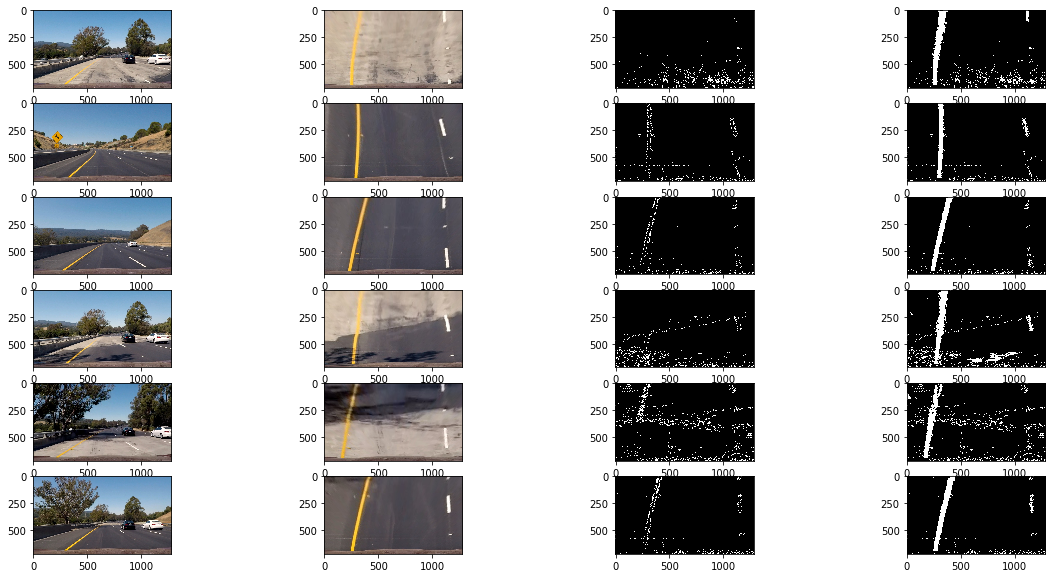

In [66]:
import scipy.misc
def conbinedThresh(image,ksize=5):
    image = grayScale(image)
    gradx = abs_sobel_thresh(image, orient='x', ksize=3, thresh=(10, 70))
#     print(gradx.shape)
    grady = abs_sobel_thresh(image, orient='y', ksize=3, thresh=(10, 70))
#     print(grady.shape)
    mag_binary = mag_thresh(image, ksize=3, thresh=(10, 80))
#     print(mag_binary.shape)
    dir_binary = dir_threshold(image, ksize=15, thresh=(0,0.4))
#     print(dir_binary.shape)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

def colorThreshold(image):
#     gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
#     thresh = (150,220) # threshold for Gray
#     binary = np.zeros_like(gray)
#     binary[(gray>thresh[0]) & (gray <= thresh[1])] = 1

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    thresh = (85, 255) # for S threshold
    binarys = np.zeros_like(S)
    binarys[(S > thresh[0]) & (S <= thresh[1])] = 1

    thresh = (15, 150) # for H threshold
    binaryh = np.zeros_like(H)
    binaryh[(H > thresh[0]) & (H <= thresh[1])] = 1
    
    conbined = np.zeros_like(H)
    conbined[(binaryh ==1) & (binarys ==1) ] = 1
    return conbined
def conbinedThreshold(img):
    colord = colorThreshold(img)
#     gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    print(gray.shape)
    combine = conbinedThresh(img)
    combined = np.zeros_like(combine)
    combined[(combine == 1) | (colord == 1)] = 1
    return combined


fig = plt.figure(figsize = (20,10))
for i in range(6):
    image = mpimg.imread("test_images/test"+str(i+1)+".jpg")
    a = fig.add_subplot(6,4,1+i*4)
    plt.imshow(image)
    a = fig.add_subplot(6,4,2+i*4)
    image = warpImage(image)
    plt.imshow(image)
    a = fig.add_subplot(6,4,3+i*4)
    plt.imshow(conbinedThresh(image),cmap="gray")
    a = fig.add_subplot(6,4,4+i*4)
    warp_image = conbinedThreshold(image)
    plt.imshow(warp_image,cmap="gray")
    scipy.misc.imsave('test_images/binary_warped'+str(i+1)+'.jpg', warp_image)
    

360
(1280,)
out_image shape:  (720, 1280, 3)
640
leftx_base:  191  rightx_base:  1131
(111, 640) (271, 720)
(107, 560) (267, 640)
(107, 480) (267, 560)
(114, 400) (274, 480)
(127, 320) (287, 400)
(130, 240) (290, 320)
(141, 160) (301, 240)
(161, 80) (321, 160)
(182, 0) (342, 80)
leftx: [112 113 116 ..., 315 318 319]
lefty: [640 640 640 ...,  79  79  79]
righty: [640 640 640 ...,  79  79  79]
rightx: [1051 1054 1056 ..., 1106 1107 1111]


(720, 0)

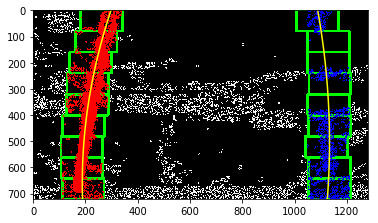

In [67]:
binary_warped = mpimg.imread("test_images/binary_warped5.jpg")
print(int(binary_warped.shape[0]/2))
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
print(histogram.shape)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

print('out_image shape: ',out_img.shape)
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
print(midpoint)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print("leftx_base: ",leftx_base," rightx_base: ",rightx_base)
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 80
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []


for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    print((win_xleft_low,win_y_low),(win_xleft_high,win_y_high))
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 10) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 10) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 
print('leftx:',leftx)
print('lefty:',lefty)
print('righty:',righty)
print('rightx:',rightx)
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

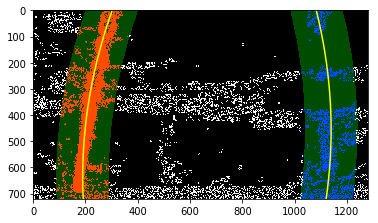

In [68]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

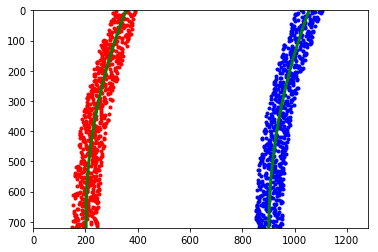

In [69]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [70]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

1530.4303878 1688.01057985
502.256730811 m 554.432809775 m


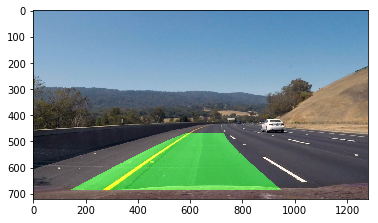

In [72]:
image = mpimg.imread("test_images/test3.jpg")
# image = undistortImage(image)
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
plt.imshow(result)

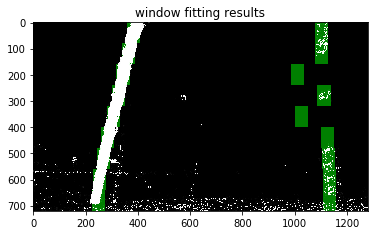

In [74]:
warped = mpimg.imread("test_images/binary_warped3.jpg")
# Read in a thresholded image
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

#If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()
